In [1]:
import sys
import os

# Add the parent directory of 'vegetation-period-NDVI' to the sys.path
sys.path.append(os.path.abspath(os.path.join("..")))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import ee
import geemap 
import seaborn as sns
from datetime import datetime
from typing import List
import matplotlib as mpl

from validate_dowscaled_et import prepare_data_for_plotting
from utils.plot_config import set_plot_style
from time_series_metrics import calculate_metrics

import warnings
warnings.filterwarnings("ignore")

In [3]:
ee.Initialize(project="thurgau-irrigation")

## Some helper functions

In [4]:
def store_collection_dates(collection: ee.ImageCollection) -> pd.DataFrame:
    """
    Store the dates of all images in an ImageCollection in a pandas DataFrame.

    Args:
        collection (ee.ImageCollection): The input image collection.

    Returns:
        pd.DataFrame: A pandas DataFrame containing the dates in datetime format.
    """
    dates = collection.aggregate_array("system:time_start")
    formatted_dates = dates.map(lambda d: ee.Date(d).format("YYYY-MM-dd"))
    date_list = formatted_dates.getInfo()

    date_df = pd.DataFrame({"date": pd.to_datetime(date_list)})

    return date_df

In [5]:
def aggregate_time_series(daily_data: pd.DataFrame, validation_dates: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregate daily time series data based on sample dates.

    Args:
        daily_data (pd.DataFrame): Daily time series with date index and 'evapotranspiration_[mm/d]' column.
        validation_dates (pd.DataFrame): DataFrame with 'date' column containing validation dates.

    Returns:
        pd.DataFrame: Aggregated data with sample dates and average values.
    """
    daily_data.index = pd.to_datetime(daily_data.index)
    
    # Convert validation_dates to datetime and sort
    validation_dates['date'] = pd.to_datetime(validation_dates['date'])
    validation_dates = validation_dates.sort_values('date')
    
    # Create bins for grouping
    bins = validation_dates['date'].tolist() + [daily_data.index.max() + pd.Timedelta(days=1)]
    
    # Cut the daily data into groups based on the bins
    daily_data['group'] = pd.cut(daily_data.index, bins=bins, labels=validation_dates['date'], right=False)
    
    # Group by the cut and calculate the mean
    aggregated_data = daily_data.groupby('group')['evapotranspiration_[mm/d]'].mean().reset_index()
    
    # Rename columns for clarity
    aggregated_data.columns = ['date', 'average_evapotranspiration_[mm/d]']
    
    return aggregated_data

In [6]:
def set_negative_to_zero(image: ee.Image) -> ee.Image:
    """
    Set all negative values in an image to zero.

    Args:
        image (ee.Image): The input image.

    Returns:
        ee.Image: The image with all negative values set to zero.
    """
    return image.where(image.lt(0), 0)

In [7]:
def merge_et_collections(years: List[int]) -> ee.ImageCollection:
    """
    Merge ET collections for multiple years.
    
    Args:
        years (list): List of years to process.
    
    Returns:
        ee.ImageCollection: Merged ET collection for all years.
    """
    collections = [
        ee.ImageCollection(f"projects/thurgau-irrigation/assets/Thurgau/ET_WaPOR_10m_dekadal_{year}")
        .sort("system:time_start")
        .map(set_negative_to_zero)
        for year in years
    ]
    
    # Merge all collections into one
    merged_collection = collections[0]
    for collection in collections[1:]:
        merged_collection = merged_collection.merge(collection)
    
    return merged_collection

In [8]:
def extract_pixel_values(
    image_collection: ee.ImageCollection, point: ee.Geometry.Point
) -> ee.FeatureCollection:
    """
    Extract the pixel value of the 'downscaled' band for each image in the collection
    at the specified point, with error handling for missing timestamps.

    Args:
        image_collection (ee.ImageCollection): The input image collection.
        point (ee.Geometry.Point): The point at which to extract values.

    Returns:
        ee.FeatureCollection: A feature collection where each feature represents an image
                              and contains the pixel value of the 'downscaled' band at the point.
    """

    def extract_value(image: ee.Image) -> ee.Feature:
        # Select the 'downscaled' band
        downscaled = image.select("downscaled")

        # Get the scale of the 'downscaled' band
        scale = downscaled.projection().nominalScale()

        # Extract the pixel value at the point
        pixel_value = downscaled.reduceRegion(
            reducer=ee.Reducer.first(),
            geometry=point,
            scale=scale,
            bestEffort=True,
        ).get("downscaled")

        # Retrieve the image acquisition time
        time_start = image.get("system:time_start")

        # Handle potential null time_start
        formatted_date = ee.Algorithms.If(
            ee.Algorithms.IsEqual(time_start, None),
            None,
            ee.Date(time_start).format("YYYY-MM-dd"),
        )

        return ee.Feature(
            None,
            {
                "pixel_value": pixel_value,
                "date": formatted_date,
                "system:time_start": time_start,
            },
        )

    # Map the extraction function over the image collection
    return ee.FeatureCollection(image_collection.map(extract_value))

### Import validation data and WaPOR ET data

In [9]:
years_to_process = [2018, 2019, 2020, 2021]

et_collection = merge_et_collections(years_to_process)
dates_for_validation = store_collection_dates(et_collection)

In [10]:
print(dates_for_validation) 

          date
0   2018-01-01
1   2018-01-11
2   2018-01-21
3   2018-02-01
4   2018-02-11
..         ...
138 2021-11-11
139 2021-11-21
140 2021-12-01
141 2021-12-11
142 2021-12-21

[143 rows x 1 columns]


In [11]:
rietholzbach_validation_et_collection = ee.FeatureCollection("projects/thurgau-irrigation/assets/Thurgau/ETFluxNet/ET_timeseries_rietholzbach_2017_2021").sort("system:time_start")

In [12]:
# Map = geemap.Map()
# point = validation_et_collection.first().geometry()

# image = ee.Image(et_collection.toList(144).get(50))

# Map.centerObject(point, 12)
# Map.addLayer(point, {"color": "red"}, "point")
# options = {
#     "bands": ["downscaled"],
#     "min": 0,
#     "max": 300,
#     "palette": ["blue", "white", "orange", "red"],
# }
# Map.addLayer(image, options, "ET")

# Map

In [13]:
rietholzbach_validation_df = geemap.ee_to_df(rietholzbach_validation_et_collection)

In [14]:
rietholzbach_validation_df["date"] = pd.to_datetime(rietholzbach_validation_df["date_[YYYYmmdd]"])
rietholzbach_validation_df = rietholzbach_validation_df.drop(columns=["date_[YYYYmmdd]"])
rietholzbach_validation_df = rietholzbach_validation_df.set_index("date")
rietholzbach_validation_df = rietholzbach_validation_df.resample("D").asfreq()
rietholzbach_validation_df = rietholzbach_validation_df.interpolate(method='time')

print(rietholzbach_validation_df.tail(20))

            evapotranspiration_[mm/d]
date                                 
2021-12-12                     1.0820
2021-12-13                     1.3050
2021-12-14                     0.6525
2021-12-15                     0.0000
2021-12-16                     0.0000
2021-12-17                     0.0000
2021-12-18                     0.6960
2021-12-19                     0.4640
2021-12-20                     0.2320
2021-12-21                     0.0000
2021-12-22                     0.0000
2021-12-23                     0.0000
2021-12-24                     0.0000
2021-12-25                     0.0000
2021-12-26                     0.0000
2021-12-27                     0.0000
2021-12-28                     0.0000
2021-12-29                     0.0000
2021-12-30                     0.0000
2021-12-31                     0.0000


In [15]:
# validation_ET = validation_df.loc[dates_for_validation['date']]
# validation_ET

rietholzbach_validation_ET = aggregate_time_series(rietholzbach_validation_df, dates_for_validation)
print(rietholzbach_validation_ET)

          date  average_evapotranspiration_[mm/d]
0   2018-01-01                           0.040400
1   2018-01-11                           0.044800
2   2018-01-21                           0.254091
3   2018-02-01                           0.177100
4   2018-02-11                           0.311750
..         ...                                ...
138 2021-11-11                           0.145500
139 2021-11-21                           0.204700
140 2021-12-01                           0.095800
141 2021-12-11                           0.497250
142 2021-12-21                           0.000000

[143 rows x 2 columns]


In [16]:
point = rietholzbach_validation_et_collection.first().geometry()
raster_collection = extract_pixel_values(et_collection, point)

In [17]:
waport_df = geemap.ee_to_df(ee.FeatureCollection(raster_collection))
waport_df["evapotranspiration[mm/d]"] = waport_df["pixel_value"] / 100
waport_df["date"] = pd.to_datetime(waport_df["date"])

### Visually validate the WAPOR ET data

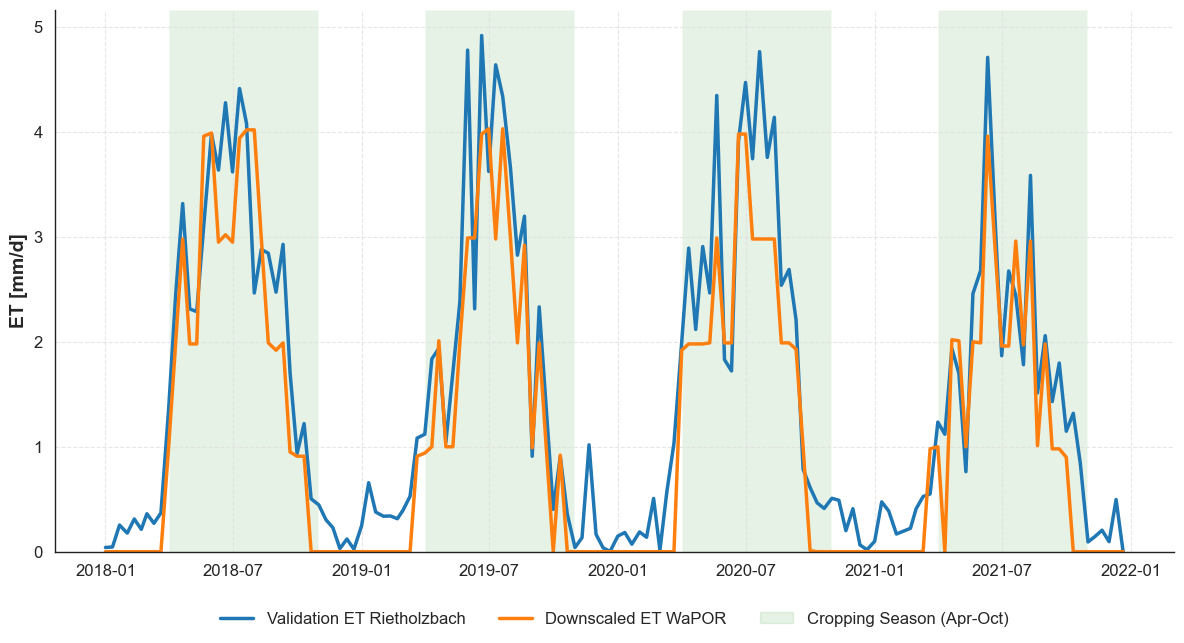

In [18]:
import matplotlib.patches as mpatches

set_plot_style()  # Assuming this function is defined elsewhere

plt.figure(figsize=(12, 7))  # Increased height to accommodate bottom legend

# Plot the data
sns.lineplot(data=rietholzbach_validation_ET, x="date", y="average_evapotranspiration_[mm/d]", label="Validation ET Rietholzbach", color="#1f77b4")
sns.lineplot(data=waport_df, x="date", y="evapotranspiration[mm/d]", label="Downscaled ET WaPOR", color="#ff7f0e")

# Set labels
plt.xlabel("")
plt.ylabel("ET [mm/d]")

plt.ylim(bottom=0)  

# Add green background for April to October
for year in range(rietholzbach_validation_ET['date'].dt.year.min(), rietholzbach_validation_ET['date'].dt.year.max() + 1):
    plt.axvspan(pd.Timestamp(f"{year}-04-01"), pd.Timestamp(f"{year}-10-31"), 
                facecolor='green', alpha=0.1, zorder=0)

# Create a custom patch for the legend
green_patch = mpatches.Patch(color='green', alpha=0.1, label='Cropping Season (Apr-Oct)')

# Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(green_patch)

# Place the legend at the bottom with 3 columns
plt.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, -0.15), 
            ncol=3, borderaxespad=0.)

# Adjust layout to prevent cutting off the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Adjust bottom margin to fit the legend


plt.savefig("/Users/cooper/Desktop/Hydrosolutions/ETblue-estimation /images/ET_validation/WaPOR_validation_Rietholzbach_10d_aggregate.png", dpi=300, bbox_inches="tight")
plt.show()

### Quantitative validation

In [19]:
metrics = calculate_metrics(rietholzbach_validation_ET['average_evapotranspiration_[mm/d]'], waport_df['evapotranspiration[mm/d]'])

In [20]:
metrics

{'R-squared': 0.7412654399116794,
 'Correlation Coefficient': 0.912562102501347,
 'Dynamic Time Warping Distance': 4.9640956312194335,
 'Mean Absolute Error': 0.5005204280567915,
 'Root Mean Square Error': 0.6799551877536019,
 'Normalized Root Mean Square Error': 0.16872337165101783}